# Adversarial attack on pretrained model

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable
from copy import copy, deepcopy

In [2]:
from fastai.basics import *


###Load dataset

In [3]:
def load_data(batch_size=64):
  path = untar_data(URLs.IMAGENETTE)
  dir = [x for x in path.iterdir()]
  transform = transforms.Compose(
      [transforms.Resize([224,224]),
   #    transforms.Scale(224),
       transforms.CenterCrop(224),
       transforms.ToTensor(),
       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])]
  )
  data_train = datasets.ImageFolder(root=dir[0], transform=transform)
  train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True)

  data_val = datasets.ImageFolder(root=dir[1], transform=transform)
  val_loader = torch.utils.data.DataLoader(data_val, batch_size=batch_size, shuffle=True)

  return train_loader, val_loader

In [4]:
train_loader, val_loader = load_data(batch_size=64)
dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_loader.dataset), 'val': len(val_loader.dataset)}


In [5]:
print(dataset_sizes)

{'train': 9469, 'val': 3925}


### Prepare and show image

In [7]:
def show_img(img, label):
  img = img.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  img = std * img + mean
  img = np.clip(img, 0, 1)
  plt.title('label: {}'.format(label))
  plt.imshow(img)

###Some examples of images from dataset

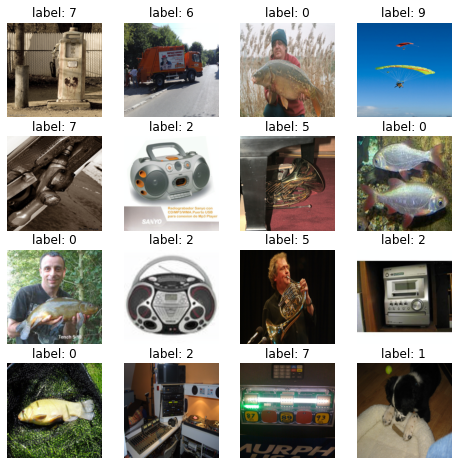

In [ ]:
fig = plt.figure(figsize=(8,8))
columns = 4;
rows = 4;
for i in range(1, columns*rows+1):
    index = np.random.randint(len(val_loader.dataset))
    img, label = val_loader.dataset[index]
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    show_img(img, label)



###Training model with changed last layer

In [6]:
num_classes = 10
num_epochs = 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [16]:
def train_model(model, criterion, optimizer, dataloaders, dataset_sizes):

  for epoch in range(num_epochs):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_correct = 0

      for inputs, labels in dataloaders[phase]:
        inputs = Variable(inputs.to(device))
        labels = Variable(labels.to(device))
        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)  
        loss = criterion(outputs, labels)
        if phase == 'train':
            loss.backward()
            optimizer.step()
            
        running_loss += loss.item() * inputs.size(0)
        running_correct += torch.sum(labels == preds.data)

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_correct.double() / dataset_sizes[phase]

      print('{} epoch {} loss: {:.4f}, acc: {:.4f}'.format(
                epoch, phase, epoch_loss, epoch_acc))
    print()
  return model

          


In [14]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(resnet.fc.parameters(), lr=0.001, momentum=0.9)

In [13]:
resnet = models.resnet50(pretrained=True)
for param in resnet.parameters():
  param.requires_grad = False
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(in_features=num_ftrs, out_features=num_classes)
resnet = resnet.to(device)


In [17]:
resnet10 = train_model(resnet, criterion, optimizer, dataloaders, dataset_sizes);


0 epoch train loss: 0.1311, acc: 0.9860
0 epoch val loss: 0.0943, acc: 0.9908



##Generate adversarial attack

In [22]:
def attack(model, input, target, num_iter=1000, alpha=0.005):
  model.eval()
  loss_history = []
  with torch.set_grad_enabled(True):
    img = deepcopy(input)
    output_targ = model(target)
    best_loss = 10000.
    best_img = deepcopy(img)
    img = Variable(img, requires_grad=True)
    for i in range(num_iter):
      
  #    print(img.requires_grad, [x.requires_grad for x in model.parameters()])
      output = model(img)
      loss = torch.norm(output - output_targ, p=2)
      loss.backward(retain_graph=True)
  #    loss_history.append(loss)
      if loss.item() < best_loss:
        best_loss = loss.item()
        best_img = deepcopy(img)
      img.data -= alpha * torch.sigmoid(img.grad.data)
  #    print(torch.norm(img.grad.data))
  #    print(loss.item())

  return best_img, best_loss



Initial image

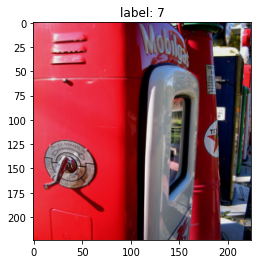

In [18]:
index1 = np.random.randint(len(val_loader.dataset))
img1, label1 = val_loader.dataset[index1]
image1 = Variable(torch.Tensor(img1)).unsqueeze(0)
image1 = image1.to(device)
show_img(img1, label1)

Target image

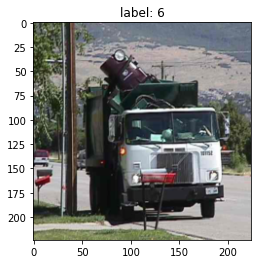

In [19]:
index2 = np.random.randint(len(val_loader.dataset))
img2, label2 = val_loader.dataset[index2]
image2 = Variable(torch.Tensor(img2)).unsqueeze(0)
image2 = image2.to(device)
show_img(img2, label2)

Generated adversarial example: have the same label as target image, but looks like initial one

In [27]:
img, loss = attack(resnet10, image1, image2, num_iter=1000, alpha=1./255)
print("Distance between adversarial example and target outputs: ", loss)

Distance between adversarial example and target outputs:  0.007813272066414356


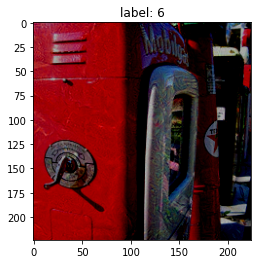

In [28]:
outputs = resnet10(img)
_, preds = torch.max(outputs, 1)
show_img(torch.reshape(img.data.cpu(), (3, 224, 224)), preds.item())